## Class 6 Agenda:
  * **Brief introduction to unsupervised learning**
  * **K-means clustering**
  * **Evaluating the quality of clustering using Silhouette coefficient**
  * **DBScan**
  * **Distance metrics and how to not misuse them**

### Unsupervised learning

In the last class, we talked about the case where we knew what we were trying to predict.

We built a model to try to predict the expected gas mileage of a car model, given certain properties of the car (**supervised regression problem**) and a different model to try to predict whether someone had a spinal abnormality given certain measurements of their back and spine (**supervised classification problem**).

Both of these were labeled machine learning problems.

What if you didn't have any labels for your data but still wanted to see if there was any structure to your dataset? This process is called **unsupervised learning**. We are trying to learn something about our dataset without having access to any outcomes variables (targets, outputs, etc.).

We are going to explore 2 common approaches for **unsupervised learning**, called **K-means clustering** and **DBSCAN**.

By the end of this lesson you will be able to:
  * use k-means and DBSCAN clustering on new data
  * explain what the k-parameter in k-means does
  * explain what $\epsilon$ and min_samples parameters in DBSCAN affect
  * use euclidean distance for numerical clustering, know what kind of data to use euclidean distance with.

As always, we are going to import everything we need for the lesson:

In [1]:
#getting and working with data
import pandas as pd
from sklearn.cluster import KMeans,DBSCAN
from sklearn.preprocessing import StandardScaler, Normalizer
import numpy as np
from sklearn.metrics.cluster import silhouette_score

#visualizing results
%matplotlib inline
import seaborn as sns

The dataset we will be using today is one of the classic datasets used in machine learning, known as the **iris dataset**. This dataset is small and very useful for investigating both clustering and classification problems, but we will be using it exclusively for clustering purposes.

You can read more about the dataset [here](https://archive.ics.uci.edu/ml/datasets/Iris). There are 4 features identifying each type of iris:
  1. sepal length in cm
  2. sepal width in cm
  3. petal length in cm
  4. petal width in cm
  
Going forward, we are going to assume we don't know the kind of iris each sample corresponds to:

In [2]:
#we're getting the data directly off the internet here! how cool is that!
iris_data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/iris/bezdekIris.data",
                        names=["sepal_length","sepal_width","petal_length","petal_width","iris_type"])
iris_data_no_names = iris_data.drop("iris_type",axis=1)
iris_data_no_names.head()
iris_data_features = iris_data_no_names.columns

Let's take a look at the dataset:

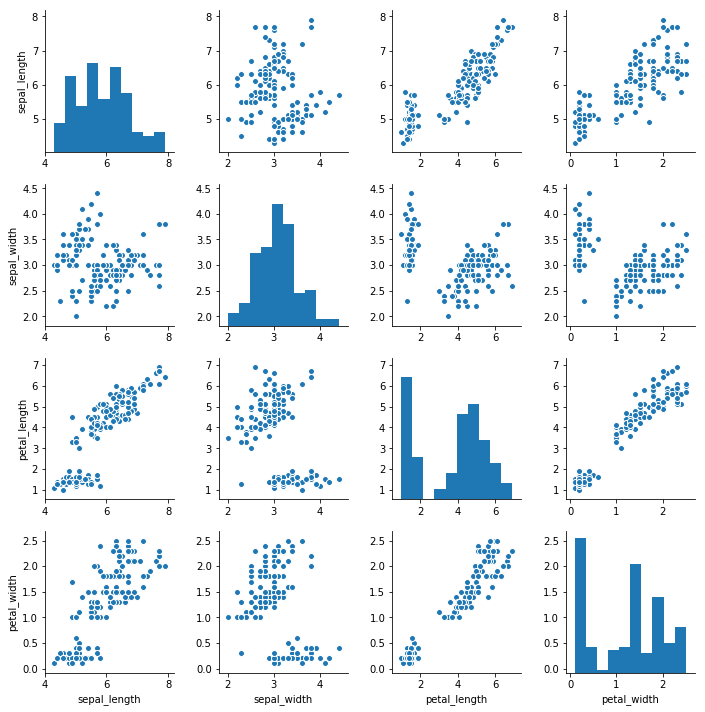

In [3]:
sns.pairplot(iris_data)

This dataset looks like it has some interesting structure! Let's see if we can't uncover and explore some of it.

At first pass, it looks like the dataset has at least 2 distinct clusters, right? So let's use k-means clustering to automatically find 2 clusters in the dataset:

In [4]:
kmeans = KMeans(n_clusters=2,random_state=1234)
kmeans.fit(iris_data_no_names[iris_data_features])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=1234, tol=0.0001, verbose=0)

**K-means clustering** takes a single parameter, which is the number of clusters you want the underlying data to fall into, and attempts to find those clusters automatically as follows:
  1. Initially generate random cluster centers equal to the number of clusters
  2. For each sample (row), label it with the cluster center it is closest to by computing the [euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance) between it and each cluster center
  3. Generate new cluster centers for each cluster based on the labelings for each point.
  4. Repeat steps 2-3 until one of the following stopping criteria is met: 
    * small fraction of samples change labelings
    * cluster centers change position by a very small amount.

Before we look at the generated clusters for our dataset, we should understand how **euclidean distance** computes the distance between points in our dataset.

Here is the euclidean distance formula for finding the distance between two points, x and y, which have features i=1 to i=k (k features):

$d(x,y)=\sqrt {\sum_{i=1}^{k}(x_i-y_i)^2}$

So, it is simply the length of the path connecting them, as defined using the [Pythagorean theorem](https://en.wikipedia.org/wiki/Pythagorean_theorem). It is simply finding the square of the difference on each feature, summing across all features, and taking the square root, to make the distance be "on the same scale" as the original measurement. (Think about what this means when the feature columns have vastly different scales).

sepal_length    float64
sepal_width     float64
petal_length    float64
petal_width     float64
kmeans_2         object
dtype: object


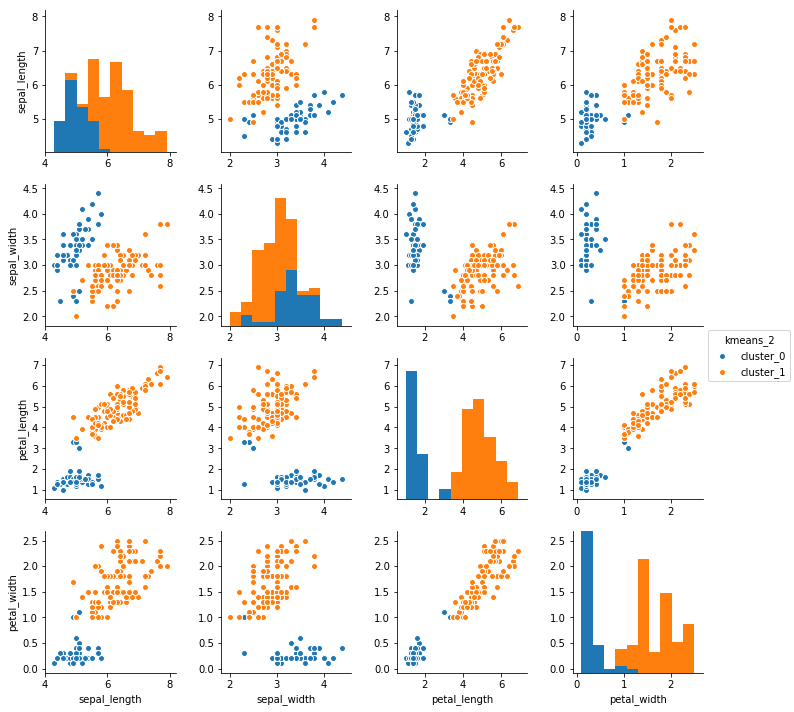

In [5]:
iris_data_no_names["kmeans_2"] = ["cluster_"+str(label) for label in kmeans.labels_]
print(iris_data_no_names.dtypes)
sns.pairplot(iris_data_no_names,hue="kmeans_2")

In [6]:
print("Cluster centers found by k-means:\n",kmeans.cluster_centers_)

Cluster centers found by k-means:
[[ 5.00566038  3.36981132  1.56037736  0.29056604]
 [ 6.30103093  2.88659794  4.95876289  1.69587629]]


In [6]:
iris_2_cluster_centers = iris_data_no_names.groupby("kmeans_2").mean()
print("Means of each column :\n",iris_2_cluster_centers.values)

Means of each column :
 [[ 5.00566038  3.36981132  1.56037736  0.29056604]
 [ 6.30103093  2.88659794  4.95876289  1.69587629]]


Let's plot the cluster centers on one of the plots we found above:

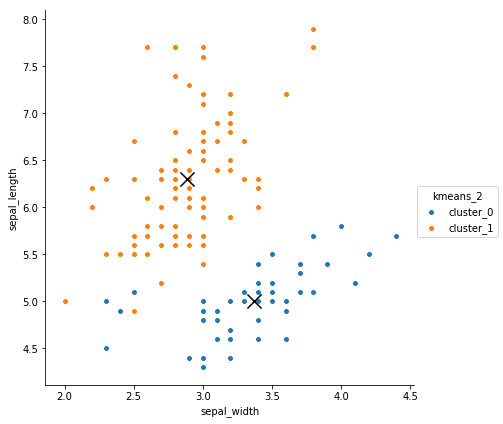

In [7]:
colors = np.array(['red', 'green'])

sns.pairplot(iris_data_no_names,x_vars="sepal_width",y_vars="sepal_length",hue="kmeans_2",size=6)
sns.mpl.pyplot.scatter(iris_2_cluster_centers.sepal_width, iris_2_cluster_centers.sepal_length, linewidths=3, marker='x', s=200, c='black')

Why are some of the points labeled strangely relative to what you would expect the overall position of the cluster centers?

**K-means** is the first algorithm we will use that **is affected by the scale of every feature**, by virtue of the fact that it uses a single distance metric (euclidean distance) across all features.

In practice, this means that for two features with very different scales of values one feature's contribution to the overall distance can dominate all distances found in the other feature:
  - Given 2 features and their original scales (difference between maximum and minimum values):
    - size in milliimeters
    - weight in kilograms
  - Distances in peoples sizes (which can vary 2 feet, about ~600mm) will dominate differences in peoples weight (which vary usually no more than ~50kg across people) because the relative scale is ~10x larger for sizes than kilograms.

What this means is that **for k-means clustering, features must be scaled to the same ranges of values to contribute "equally" to the euclidean distance calculation**.

How do we do this in practice?
We convert each sample's original value to its z-scored value:

$z_i = \frac{x_i - \mu}{\sigma}$

So, each row is transformed per-column by:
  - subtracting from the element in each row the mean for each feature (column) and then taking this value and
  - dividing by that feature's (column's) standard deviation.

Z-scoring our data allows us to compare values across columns.
Here's the two-line way of generating z-scores for our data:

In [8]:
# center and scale the data
scaler = StandardScaler()
iris_data_scaled = scaler.fit_transform(iris_data_no_names[iris_data_features])
iris_data_scaled = pd.DataFrame(iris_data_scaled,columns=iris_data_features)
print("Before scaling:\n", iris_data_no_names[iris_data_features].describe())
print("\nAfter scaling:\n", np.round(iris_data_scaled.describe(),2))

Before scaling:
        sepal_length  sepal_width  petal_length  petal_width
count    150.000000   150.000000    150.000000   150.000000
mean       5.843333     3.057333      3.758000     1.199333
std        0.828066     0.435866      1.765298     0.762238
min        4.300000     2.000000      1.000000     0.100000
25%        5.100000     2.800000      1.600000     0.300000
50%        5.800000     3.000000      4.350000     1.300000
75%        6.400000     3.300000      5.100000     1.800000
max        7.900000     4.400000      6.900000     2.500000

After scaling:
        sepal_length  sepal_width  petal_length  petal_width
count        150.00       150.00        150.00       150.00
mean          -0.00        -0.00         -0.00        -0.00
std            1.00         1.00          1.00         1.00
min           -1.87        -2.43         -1.57        -1.45
25%           -0.90        -0.59         -1.23        -1.18
50%           -0.05        -0.13          0.34         0.13
75%   

In [9]:
# K-means on scaled data
km = KMeans(n_clusters=2,random_state=1234)
km.fit(iris_data_scaled)
iris_data_no_names['kmeans_2_scaled'] = [ "cluster_" + str(label) for label in km.labels_ ]
print(km.cluster_centers_)
iris_data_no_names.groupby('kmeans_2_scaled').mean()

[[-1.01457897  0.85326268 -1.30498732 -1.25489349]
 [ 0.50728948 -0.42663134  0.65249366  0.62744675]]


,sepal_length,sepal_width,petal_length,petal_width
kmeans_2_scaled,,,,
cluster_0,5.006,3.428,1.462,0.246
cluster_1,6.262,2.872,4.906,1.676


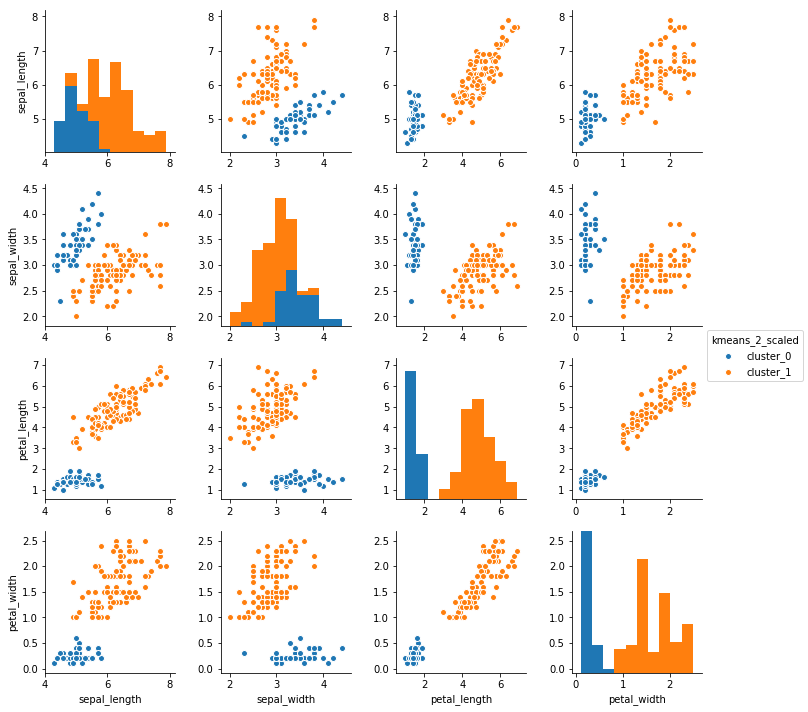

In [10]:
sns.pairplot(iris_data_no_names,hue="kmeans_2_scaled")

See the difference in cluster labels after scaling has been performed? The clusters are much cleaner!

What happens if we increase the number of clusters?

In [11]:
km3 = KMeans(n_clusters=3,random_state=1234)
km3.fit(iris_data_scaled)
iris_data_no_names['kmeans_3_scaled'] = [ "cluster_" + str(label) for label in km3.labels_ ]
print(km3.cluster_centers_)
iris_data_no_names.groupby('kmeans_3_scaled').mean()

[[ 1.13140499  0.07903422  0.98537152  0.99908828]
 [-1.01457897  0.85326268 -1.30498732 -1.25489349]
 [-0.06881714 -0.89339955  0.34522179  0.28439302]]


,sepal_length,sepal_width,petal_length,petal_width
kmeans_3_scaled,,,,
cluster_0,6.777083,3.091667,5.491667,1.958333
cluster_1,5.006000,3.428000,1.462000,0.246000
cluster_2,5.786538,2.669231,4.365385,1.415385


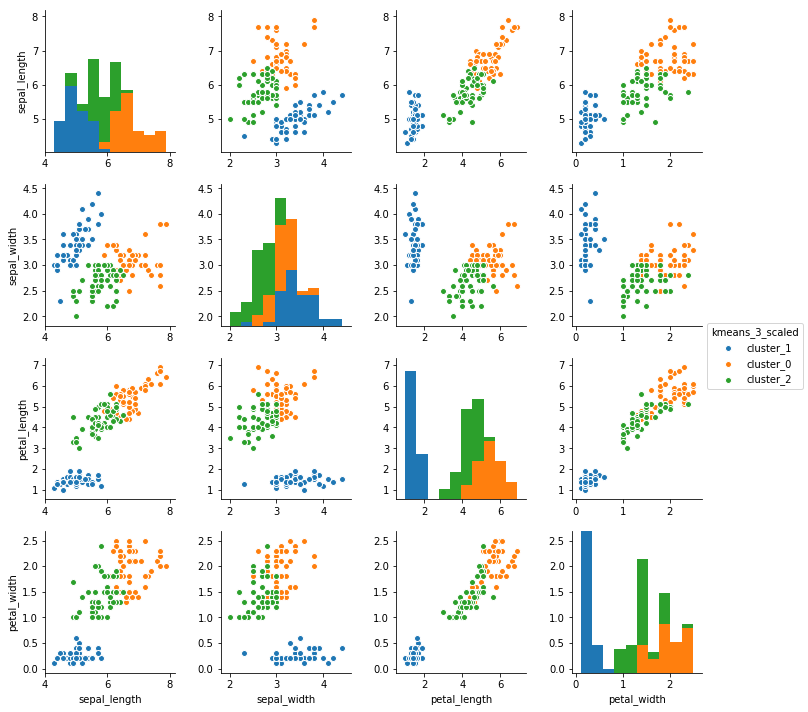

In [12]:
sns.pairplot(iris_data_no_names,hue="kmeans_3_scaled")

#### Exercise Time!!!
  * Generate k-means clustering for 4, 5, and 6 clusters.
  * How many samples are there per cluster for each clustering type?
  * How do you decide which number of clusters is best?

In [13]:
pass

### Using silhouette coefficient to evalualte quality of clustering

The [**Silhouette Coefficient**](http://scikit-learn.org/stable/modules/clustering.html#silhouette-coefficient) is a common metric for evaluating clustering "performance" in situations when the "true" cluster assignments are not known.

A Silhouette Coefficient is calculated for each observation:

$$ SC=\frac {b−a}{max(a,b)}$$

a = mean distance to all other points in its cluster
b = mean distance to all other points in the next nearest cluster
It ranges from -1 (worst) to 1 (best). A global score is calculated by taking the mean score for all observations.

Let's calculate the silhouette coefficient for our original clustering (when k=2):

In [14]:
print("Silhouette score when k=2:",silhouette_score(iris_data_scaled, km.labels_))

Silhouette score when k=2: 0.581750049198


Now let's calculate and plot the silhouette score for between 1 and 15 clusters:

Text(0,0.5,'Silhouette Coefficient')

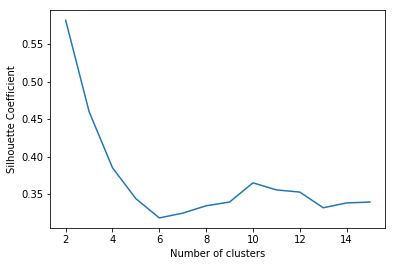

In [15]:
k_range = range(2,16)
scores = []
for k in k_range:
    km_ss = KMeans(n_clusters=k, random_state=1)
    km_ss.fit(iris_data_scaled)
    scores.append(silhouette_score(iris_data_scaled, km_ss.labels_))

# plot the results
sns.mpl.pyplot.plot(k_range, scores)
sns.mpl.pyplot.xlabel('Number of clusters')
sns.mpl.pyplot.ylabel('Silhouette Coefficient')

#### Exercise Time!!!

I've provided you with the following [seeds dataset](https://archive.ics.uci.edu/ml/datasets/seeds). Each row in the dataset is an individual seed. The individual columns are as follows:
  1. seed area A
  2. seed perimeter P 
  3. compactness $C = 4*\pi*(\frac {A}{P})^2$
  4. length of kernel 
  5. width of kernel 
  6. asymmetry coefficient 
  7. length of kernel groove
  
In the data I've loaded in, I've explicitly removed the seed labeling so that you can explore the data yourself.

Please do the following:
  * Perform clustering using a variety of cluster sizes
  * Calculate the silhouette score for each cluster size and determine an optimal cluster number
  * Visualize the clustering and compute statistics on those clusters. What distinguishes each cluster you've created?

In [16]:
seed_data = pd.read_csv("../data/seeds_dataset.txt",names=["area","perimeter","compactness","length","width","asymmetry","kernel_groove_length","seed_type"])
seed_data.drop("seed_type",axis=1,inplace=True)
seed_data.head()

,area,perimeter,compactness,length,width,asymmetry,kernel_groove_length
0,15.26,14.84,0.8710,5.763,3.312,2.221,5.220
1,14.88,14.57,0.8811,5.554,3.333,1.018,4.956
2,14.29,14.09,0.9050,5.291,3.337,2.699,4.825
3,13.84,13.94,0.8955,5.324,3.379,2.259,4.805
4,16.14,14.99,0.9034,5.658,3.562,1.355,5.175


In [17]:
pass

### DBSCAN

The second clustering algorithm we are going to investigate is called **DBSCAN** and works a bit differently than K-means.[DBSCAN wiki](https://en.wikipedia.org/wiki/DBSCAN)

**DBSCAN** stands for **Density-based spatial clustering of applications with noise**.

Whereas K-means does not care about the density of data, **DBSCAN** does, under the assumption that **regions of high density in your data should be treated as clusters**.

Furthermore, **DBSCAN does not allow you to specify how many clusters you want.** Instead, you specify 2 parameters:
  1. **$\epsilon$ (epsilon)**: This is the maximum distance between two points to allow them to be neighbors
  2. **min_samples**: The number of neighbors a given point is allowed to have to be able to be part of a cluster

Any points that don't satisfy the criteria of being close enough to other points are labeled outliers and all fall into a single "cluster" (their cluster label by default is -1).

DBSCAN works as follows:
  1. Choose an arbitrary starting point in your dataset that has not been seen.
  2. Retrieve this point's $\epsilon$-neighborhood (all points that are within a distance **$\epsilon$** from it), and if it contains at least ***min_samples**, a cluster is started.
  3. Otherwise, the point is labeled as an outlier (-1). **Note: This point might later be found in a sufficiently sized ε-environment of a different point and hence be made part of a cluster.**
  4. If a point is found to be a dense part of a cluster, its $\epsilon$-neighborhood is also part of that cluster. All points that are found within the $\epsilon$-neighborhood are added, as is their own $\epsilon$-neighborhood when they are also dense.
  5. Continue until the density-connected cluster is completely found.
  6. Find a new unvisited point to process, rinse and repeat.

There are 2 very big differences between **DBSCAN** and **K-means** clustering:
  1. **DBSCAN determines the number of clusters automatically whereas K-means requires #of clusters as a parameter.**
  2. **DBSCAN takes any distance metric you want, whereas K-means only works with euclidean distance.**
  
What this means in practice is that **DBSCAN** is very sensitive to:
  1. what distance metric you choose
  2. what you set $\epsilon$ and **min_samples** to

Let's work through using DBSCAN on the Iris dataset, and see what happens when we use 

First, we create a DBSCAN object, then we fit it to our scaled iris data. By default, DBSCAN uses euclidean distance:

In [18]:
db = DBSCAN(eps=1, min_samples=3)
db.fit(iris_data_scaled)

DBSCAN(algorithm='auto', eps=1, leaf_size=30, metric='euclidean',
    metric_params=None, min_samples=3, n_jobs=1, p=None)

In [19]:
db.labels_

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

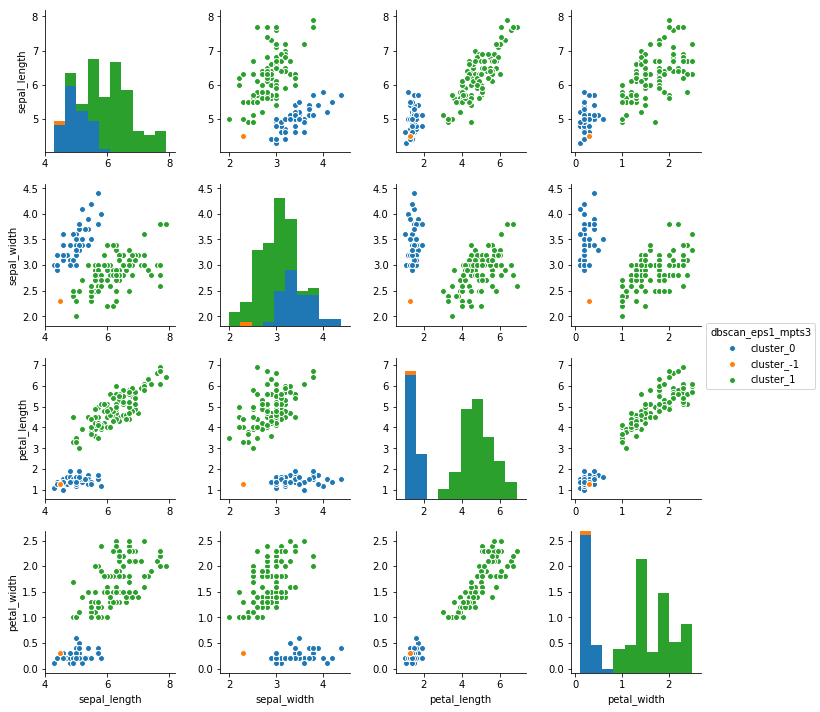

In [20]:
iris_data_no_names['dbscan_eps1_mpts3'] = [ "cluster_" + str(label) for label in db.labels_ ]
sns.pairplot(iris_data_no_names,hue="dbscan_eps1_mpts3")

What happens as we alter either $\epsilon$ or min_samples?

Let's first alter min_samples:

In [21]:
db2 = DBSCAN(eps=1, min_samples=10)
db2.fit(iris_data_scaled)
db2.labels_

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

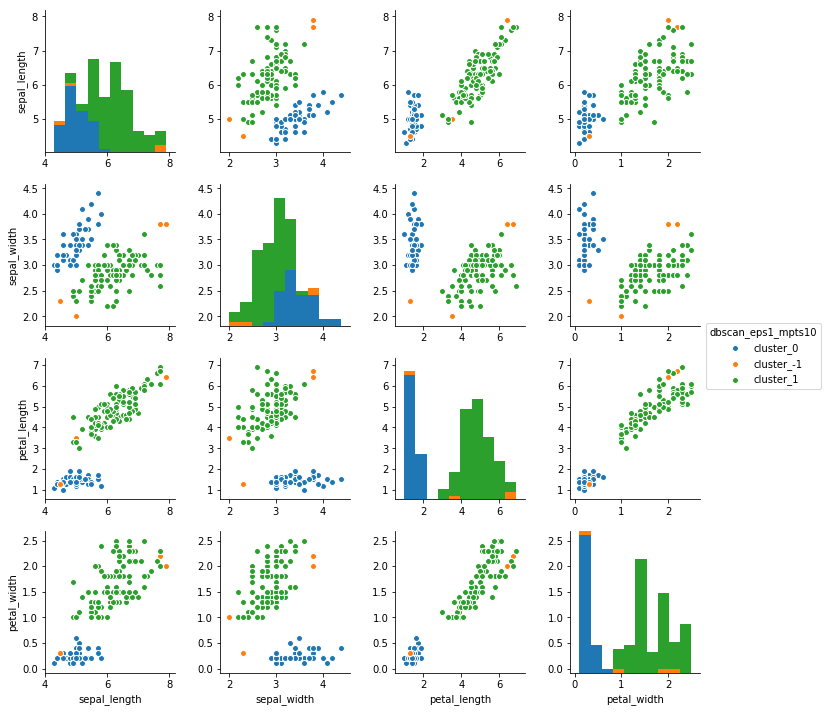

In [22]:
iris_data_no_names['dbscan_eps1_mpts10'] = [ "cluster_" + str(label) for label in db2.labels_ ]
sns.pairplot(iris_data_no_names,hue="dbscan_eps1_mpts10")

So, as we increase **min_samples**, we get more outliers. This makes sense, as increasing the number of points needed to make a cluster becomes harder the larger the number of points we need.

Points that are themselves far away from large collections of points now become outliers.

What about when we increase $\epsilon$?

In [23]:
db3 = DBSCAN(eps=2, min_samples=3)
db3.fit(iris_data_scaled)
db3.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

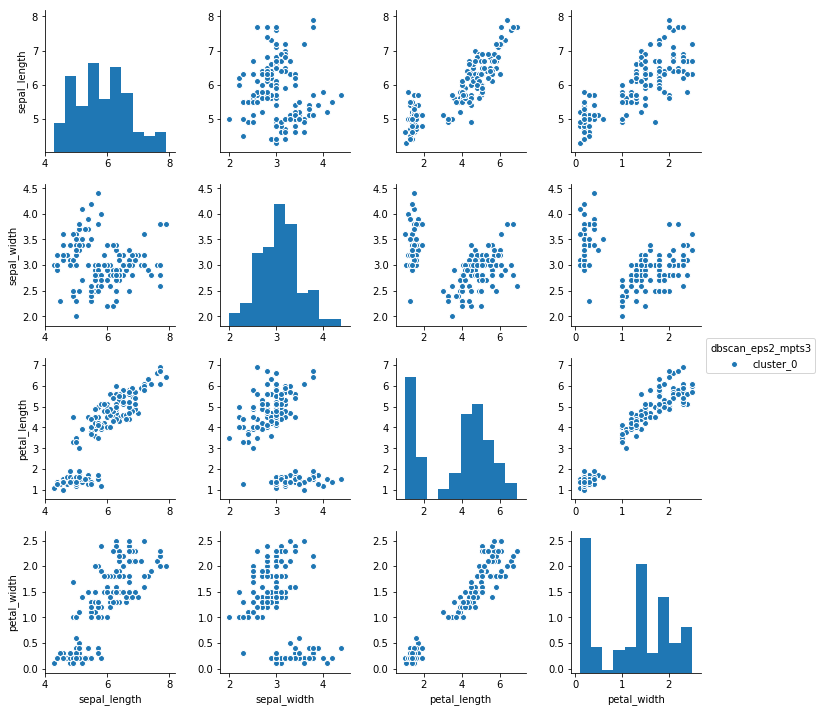

In [24]:
iris_data_no_names['dbscan_eps2_mpts3'] = [ "cluster_" + str(label) for label in db3.labels_ ]
sns.pairplot(iris_data_no_names,hue="dbscan_eps2_mpts3")

So, increasing $\epsilon$ has a different effect from increasing **min_samples**, in that it causes clusters to be merged.

This should make sense to you, because as you increase the distance for any points to be $\epsilon$-connected, it becomes easier to force distant points to be part of the same cluster.

Just to hammer this home, lets try to cluster our dataset using a smaller $\epsilon$, to illustrate that it causes more clusters to form:

In [25]:
db4 = DBSCAN(eps=0.6, min_samples=3)
db4.fit(iris_data_scaled)
db4.labels_

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0,  0,  0,  1,
        1,  1,  1,  1,  1,  1,  2,  1,  1, -1,  1, -1,  1,  1,  1,  1,  1,
        3,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  3,  1,  1,  1,  1,  1,  2,  1,  1,  1,  1,  2,  1,  1,  1,
        1,  1,  1,  1, -1,  1, -1, -1,  1,  1,  1,  1,  1,  1,  1, -1, -1,
        3,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1])

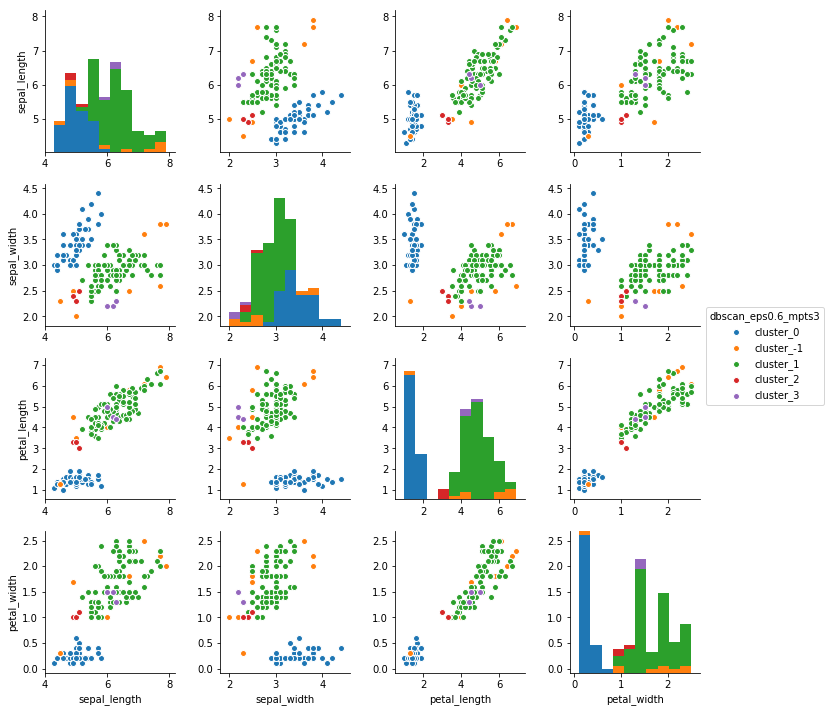

In [26]:
iris_data_no_names['dbscan_eps0.6_mpts3'] = [ "cluster_" + str(label) for label in db4.labels_ ]
sns.pairplot(iris_data_no_names,hue="dbscan_eps0.6_mpts3")

#### Exercise Time!!!

Using the seeds dataset we looked at above, please do the following:
  * Perform clustering using a variety of $\epsilon$ and **min_samples** values
  * Calculate the silhouette score for each group of parameters and determine an optimal configuration
  * Visualize the clustering and compute statistics on those clusters. What distinguishes each cluster you've created?

In [27]:
pass

### When should I use euclidean distance as a distance metric?

Many different kinds of distance metrics exist, but euclidean distance is the most commonly used (and misused) distance metric.

It is useful when:
* All of the features (columns) in your data are numeric
* There are not many feature dimensions (<100)

It is not useful when:
* Columns in your data are composed of either strings or categories, or your columns have both numeric and categorical features.
* You have 1000s of features in your dataset (because of the [curse of dimensionality](https://en.wikipedia.org/wiki/Curse_of_dimensionality))

We will talk about other distance metrics and when they should be used next week.

### Takeaways

**K-means**:
  * is a good off-the-shelf clustering algorithm when youre dealing with numerical data and have some idea of the number of clusters you are looking for in your dataset
  * requires feature scaling
  * requires specifiying the number of clusters
  * can only use the euclidean distance as a distance metric
  * is non-deterministic (will generate different cluster labelings depending on initial conditions)

**DBSCAN**:
  * is a good clustering algorithm when you are attempting to find dense and non-dense regions in your feature space but dont know the number of clusters you're looking for.
  * requires feature scaling
  * requires specifying a distance metric (euclidean is default)
  * requires specifying a minimum distance between points, $\epsilon$
  * requires specifying a minimum number of points to be called a "cluster" (min_samples), minimum is 2
  * is non-deterministic (when points are on the border between two clusters, can be assigned to either one, depending on order in which un-visited points are visited).   